In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

from os.path import join, abspath
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

project_dir = abspath("../")

if project_dir not in sys.path:
    sys.path.append(project_dir)
    print("Added {} to path".format(project_dir))
    
from stock_indicators import volatility

Added /home/igor/projects/ml_projects/timeseries to path


# Fixed Volatilty Portfolio: example on SPY 
The following is the implementation of the simple strategy of holding SPY (S&P 500 ETF) and (de-)leveraging it with the aim of keeping volatility fixed. This method was proposed in 2 papers:
1. [Daniel, Kent and Tobias J. Moskowitz (2016). “Momentum crashes”. In: Journal of Fi-
nancial Economics 122.2, pp. 221–247. ISSN : 0304-405X](https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002566?via%3Dihub)
2. [Barroso, Pedro and Pedro Santa-Clara (2015). “Momentum has its moments”. In:
Journal of Financial Economics 116.1, pp. 111–120. ISSN : 0304-405X](https://www.sciencedirect.com/science/article/abs/pii/S0304405X14002566?via%3Dihub)

I used the same approach in my Master Thesis **"Momentum and Acceleration Based Strategies Using Optimal Trend and Curvature Estimators on Sparse Data"**.

In [69]:
sp500 = pd.read_csv("SPY.csv", index_col="timestamp", parse_dates=True, infer_datetime_format=True)
sp500.head()

,close,high,low,open,volume
timestamp,,,,,
2019-11-26 14:31:00+00:00,313.36,313.4700,313.26,313.41,345590.0
2019-11-26 14:32:00+00:00,313.17,313.3911,313.13,313.37,94981.0
2019-11-26 14:33:00+00:00,313.15,313.1800,313.06,313.18,106261.0
2019-11-26 14:34:00+00:00,313.22,313.3000,313.13,313.14,129312.0
2019-11-26 14:35:00+00:00,313.31,313.3100,313.13,313.23,83107.0


<IPython.core.display.Javascript object>


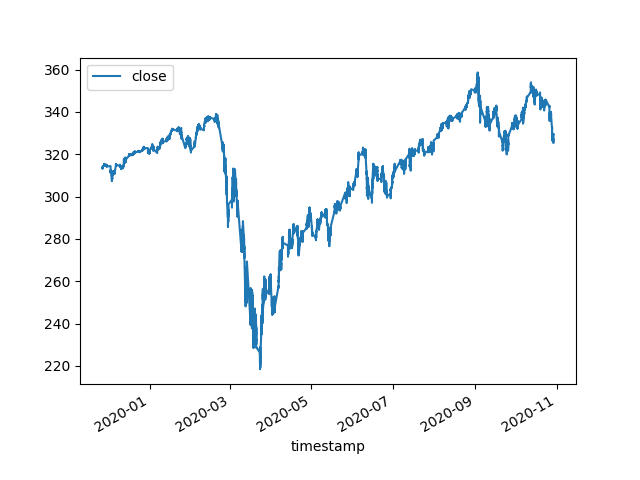

In [70]:
# we are only interested (minute) close price
sp500 = sp500[["close"]]

# remove wrong data points
sp500 = sp500.loc[sp500["close"] > 200.0]

sp500.plot()

<IPython.core.display.Javascript object>


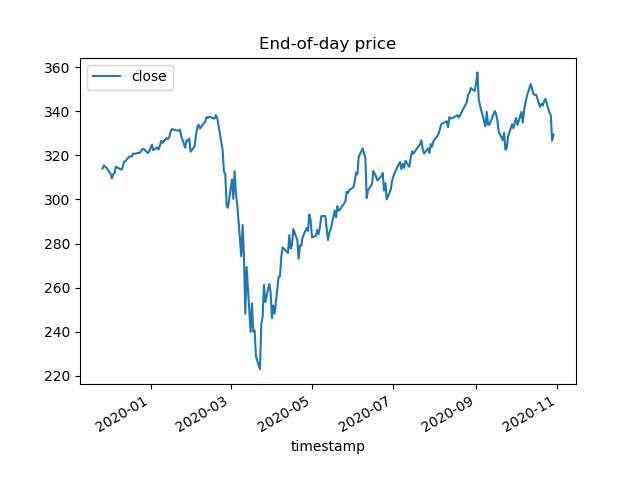

In [53]:
eod = sp500.groupby(pd.Grouper(freq="D")).last()
eod = eod.loc[~eod["close"].isna()]
fig, ax = plt.subplots()
eod.plot(ax=ax, title="End-of-day price")

<IPython.core.display.Javascript object>


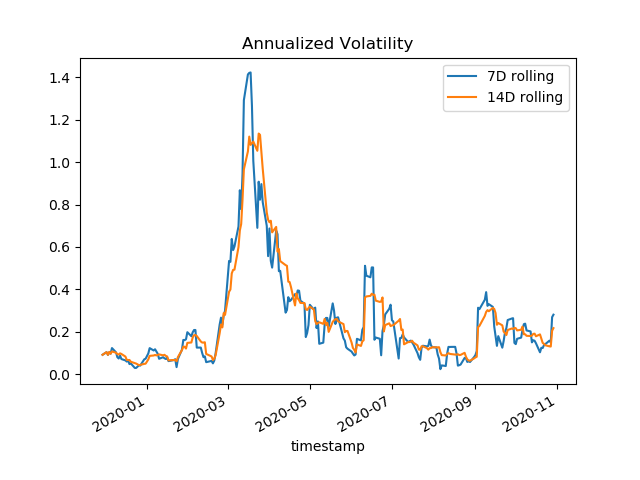

In [187]:
vola_7d = volatility(eod, window="7D")
vola_14d = volatility(eod, window="14D")

annual_7d = vola_7d * np.sqrt(252)
annual_14d = vola_14d * np.sqrt(252)
annual_7d.rename(columns={"close": "volatility"}, inplace=True)
annual_14d.rename(columns={"close": "volatility"}, inplace=True)
fig, ax = plt.subplots()
plot_vola = pd.DataFrame(
    {"7D rolling": annual_7d["volatility"], "14D rolling": annual_14d["volatility"]}
)
plot_vola.plot(ax=ax, title="Annualized Volatility")

In [188]:
# how much volatility do we want?
target_volatility = 0.15

In [189]:
# we shift calculated volatility to avoid leakage into future
shifted_volatility = annual_7d.shift(1)

merged = pd.merge(sp500, shifted_volatility["volatility"], how="outer", left_index=True, right_index=True)
merged = merged.iloc[1:]

# fill in every entry with the past day's volatility
merged["volatility"] = merged["volatility"].fillna(method="ffill")

# calculate portfolio (de-)levrage
merged["weight"] = target_volatility / merged["volatility"]
merged["weight"] = merged["weight"].fillna(0.0)
merged

,close,volatility,weight
timestamp,,,
2019-11-26 14:31:00+00:00,313.36,NaN,0.000000
2019-11-26 14:32:00+00:00,313.17,NaN,0.000000
2019-11-26 14:33:00+00:00,313.15,NaN,0.000000
2019-11-26 14:34:00+00:00,313.22,NaN,0.000000
2019-11-26 14:35:00+00:00,313.31,NaN,0.000000
...,...,...,...
2020-10-29 14:39:00+00:00,329.33,0.2691,0.557413
2020-10-29 14:40:00+00:00,329.65,0.2691,0.557413
2020-10-29 14:41:00+00:00,329.64,0.2691,0.557413


<IPython.core.display.Javascript object>


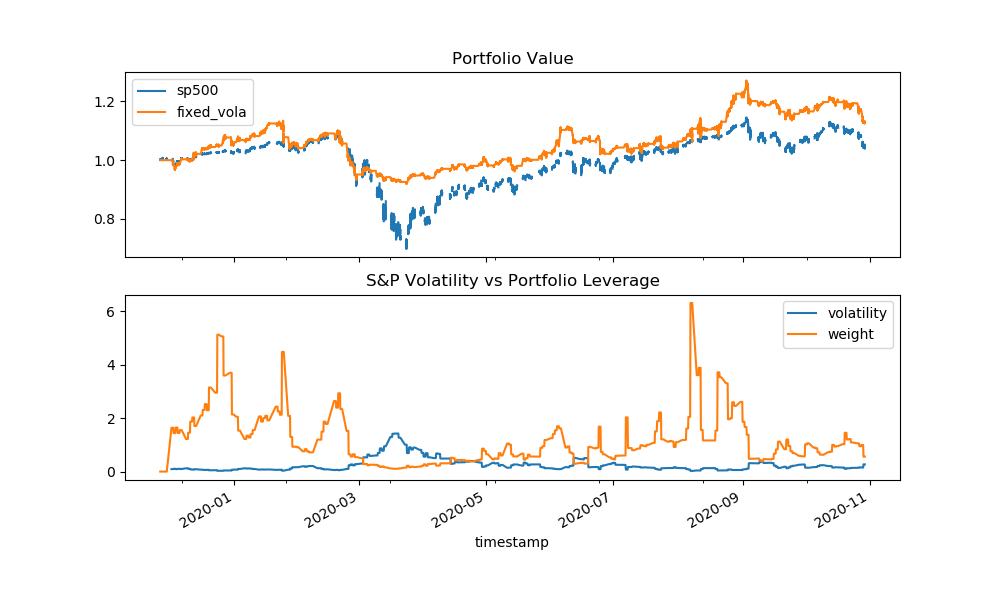

Plain SP 500 return: 5.21%
Fixed-volatility return: 13.24%


In [190]:
cap = False
if cap:
    merged["weight"] = np.minimum(merged["weight"], 2.0)

merged["sp500_return"] = merged["close"].pct_change()
merged["fixed_vola_return"] = merged["sp500_return"] * merged["weight"] 
merged["fixed_vola"] = (merged["fixed_vola_return"] + 1.0).cumprod()
merged["sp500"] = merged["close"] / merged["close"].iloc[1]
fig, ax = plt.subplots(2, sharex=True, figsize=(10,6))
merged[["sp500", "fixed_vola"]].plot(ax=ax[0], title="Portfolio Value")
merged[["volatility", "weight"]].plot(ax=ax[1], title="S&P Volatility vs Portfolio Leverage")

sp_return = (merged["sp500"].iloc[-1] - 1) * 100.0
fixed_vola_return = (merged["fixed_vola"].iloc[-1] - 1) * 100.0

print("Plain SP 500 return: %.2f%%" % sp_return)
print("Fixed-volatility return: %.2f%%" % fixed_vola_return)

<IPython.core.display.Javascript object>


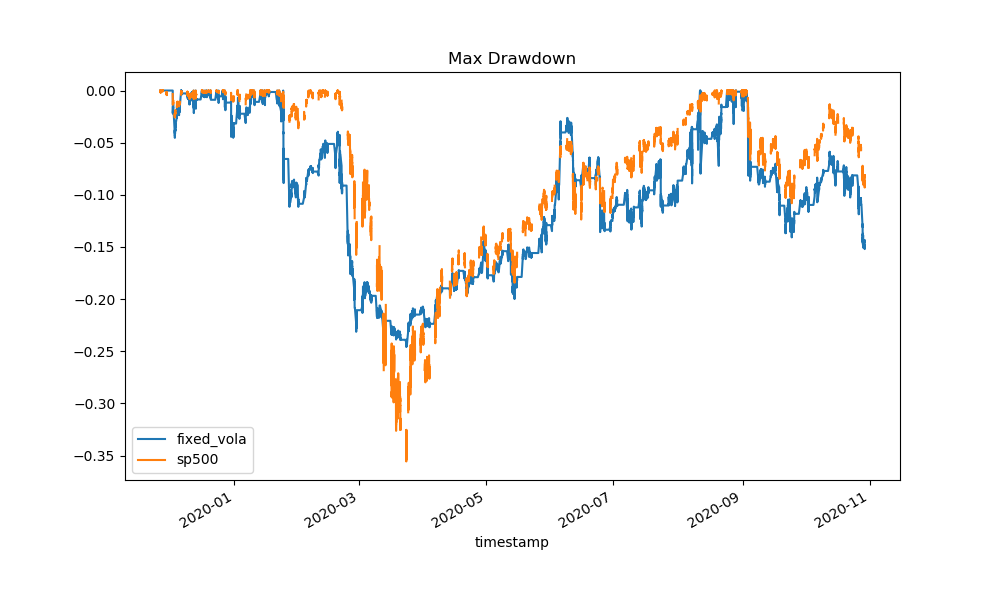

fixed_vola max drawdown: -24.59%
sp500 max drawdown: -35.57%


In [173]:
def max_drawdown(df):
    window = "360D"
    roll_max = df.rolling(window, min_periods=1).max()
    max_drawdown_plot = df/roll_max - 1.0

    # Plot the results
    fig, ax = plt.subplots(figsize=(10,6))
    max_drawdown_plot.plot(ax=ax, title="Max Drawdown")
    mdd = max_drawdown_plot.min() * 100.0
    for x, c in zip(mdd, df.columns): 
        print("%s max drawdown: %.2f%%" % (c, x))
    
max_drawdown(merged[["fixed_vola", "sp500"]])